In [40]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np 
import os  

T = 10
t_line = np.linspace(0, 100, T)

def bits_to_ascii(bit_list):
    byte_strings = ["".join(map(str, bit_list[i:i+8])) for i in range(0, len(bit_list), 8)]

    ascii_string = "".join([chr(int(byte, 2)) for byte in byte_strings])
    
    return ascii_string

def ascii_to_bits(ascii_string):
    bit_list = []
    for char in ascii_string:
        bits = bin(ord(char))[2:].zfill(8)
        bit_list.extend(map(int, bits))
    
    return bit_list

# physical channel
#PCH = np.array() 

### Часть 1 QPSK I-Q mapping

Тут просто будут коды Грея

##### Signal

$$S(t) = I\cos(2 \pi f_c \times t) - Q\sin(2 \pi f_c \times t)$$

Минимальное расстояние между точками: $$d_{min} = \sqrt{2}$$

In [41]:
def i_q_mapping(bin_level: int = 2) -> dict: 
    if (bin_level == 2): 
        return {
            "00": np.pi/4, 
            "01": 3*np.pi/4, 
            "10": 5*np.pi/4,
            "11": 7*np.pi/4 
        }
    else: 
        return {}
    
def signal_forming(samples: np.array, modulation, oversampling=10) -> np.array:
    signal = []

    # Время одного символа
    t_symbol = np.linspace(0, T, oversampling, endpoint=False)
    
    if modulation == "qpsk":
        for i in range(0, len(samples)): 
            I = samples[i][0] 
            Q = samples[i][1] 

            s_t = I * np.cos(2 * np.pi * 1/T * t_symbol) - Q * np.sin(2 * np.pi * 1/T * t_symbol) 

            signal.extend(s_t)


    return np.array(signal) 


##### Формула поворота фаз 

$$I = \cos(\Theta_{in phase})$$
$$Q = \sin(\Theta_{quadrature})$$

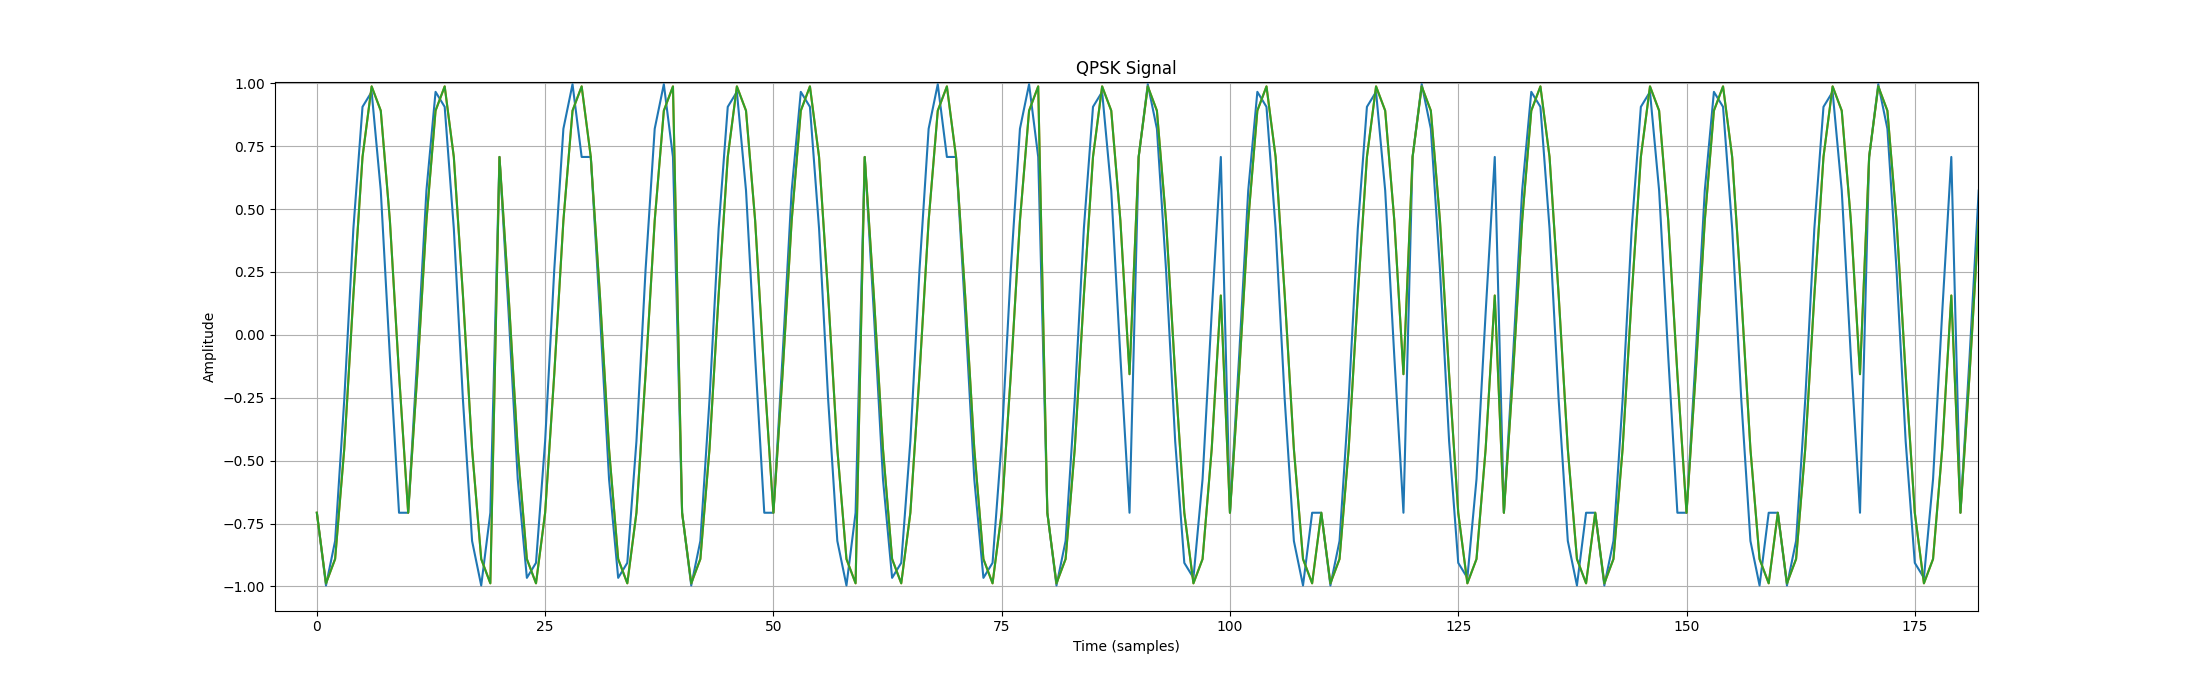

In [42]:
def i_q_qpsk_modulation(arr: np.array, bin_level: int = 2) -> np.array: 
    iq_map = i_q_mapping(bin_level)
    
    samples = []

    for i in range(0, len(arr) - 1): 
        first = arr[i]  
        second = arr[i+1]

        bits = f"{first}{second}"

        angle = iq_map[bits]; 
        
        I = np.cos(angle)
        Q = np.sin(angle)

        samples.append([I,Q]) 

    return np.array(samples, dtype=list)

test_data = np.array(ascii_to_bits("Dmitry Moskovskikh"), dtype=list)
i_q_data = i_q_qpsk_modulation(test_data)

signal = signal_forming(i_q_data, 'qpsk', oversampling=10) 

plt.plot(signal)
plt.title("QPSK Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()